- Libraries used in this assignment:

In [2]:
import os
import cv2
from glob import glob
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import random
import time
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import cv2
import shutil
from sklearn.neighbors import KNeighborsClassifier
import joblib  
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# 2. SVM Model

# 2.1. ORB Algorithm

# with visualization

Found 6515 training images.
Total descriptors shape: (375550, 32)
Training KMeans to create visual words...
Visualizing clusters using t-SNE...


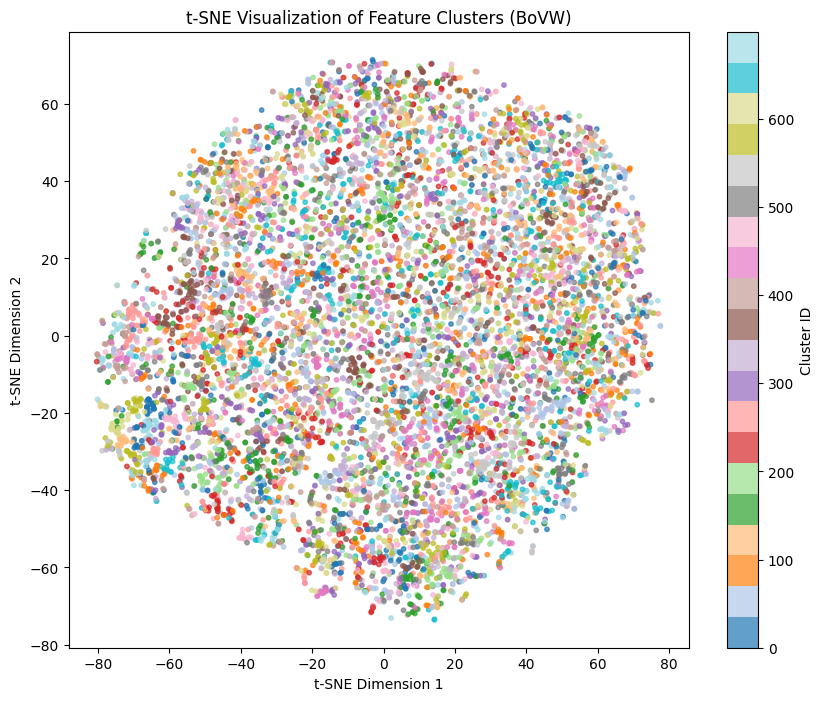

Applying TF-IDF weighting...
Training SVM classifier...
SVM training complete.
Found 1629 test images.
Test Set Accuracy: 0.13
Image: user001_abjadiyah_038.png, True Label: user001, Predicted: user037
Image: user001_abjadiyah_040.png, True Label: user001, Predicted: user034
Image: user001_azan_009.png, True Label: user001, Predicted: user001
Image: user001_fasayakfeekahum_042.png, True Label: user001, Predicted: user060
Image: user001_fasayakfeekahum_047.png, True Label: user001, Predicted: user060
Image: user001_ghaleez_011.png, True Label: user001, Predicted: user009
Image: user001_ghaleez_012.png, True Label: user001, Predicted: user042
Image: user001_ghaleez_016.png, True Label: user001, Predicted: user048
Image: user001_ghaleez_018.png, True Label: user001, Predicted: user061
Image: user001_mehras_046.png, True Label: user001, Predicted: user008
Image: user001_mustadhafeen_021.png, True Label: user001, Predicted: user008
Image: user001_mustadhafeen_024.png, True Label: user001, Pr

In [9]:
# -------------------- CONFIGURATION --------------------
train_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_new\train"
test_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_new\test"

k3 = 700

def extract_descriptors_from_saved(image_paths):
    descriptors_list = []
    labels = []

    for image_path in image_paths:
        # Locate the corresponding descriptor file
        desc_file_path = os.path.splitext(image_path)[0] + "_desc.npy"
        if os.path.exists(desc_file_path):
            descriptors = np.load(desc_file_path)  # Load saved descriptors
            descriptors_list.append(descriptors)

            # Extract label from the folder structure
            label = os.path.basename(os.path.dirname(image_path))
            labels.append(label)
        else:
            print(f"Descriptor file not found for {image_path}")
    return descriptors_list, labels
    
# -------------------- STEP 1: TRAIN KMEANS (BOVW) --------------------
# Get all training image paths
train_image_paths = glob(f"{train_dir}/**/*.png", recursive=True)
print(f"Found {len(train_image_paths)} training images.")

# Extract descriptors and labels
train_descriptors_list, train_labels = extract_descriptors_from_saved(train_image_paths)
all_descriptors = np.vstack(train_descriptors_list)
print(f"Total descriptors shape: {all_descriptors.shape}")

# Train KMeans
print("Training KMeans to create visual words...")
kmeans = KMeans(n_clusters=k3, random_state=42)
kmeans.fit(all_descriptors)

# Visualization of KMeans clusters using t-SNE
print("Visualizing clusters using t-SNE...")
# Use a subset of descriptors for speed
subset_descriptors = all_descriptors[:10000]

# Step 1: Apply PCA for dimensionality reduction
pca = PCA(n_components=16)  # Reduce to 16 dimensions (less than 32 for ORB)
reduced_descriptors = pca.fit_transform(subset_descriptors)

# Step 2: Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(reduced_descriptors)

# Assign clusters using KMeans
cluster_assignments = kmeans.predict(subset_descriptors)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_assignments, cmap='tab20', s=10, alpha=0.7)
plt.colorbar(scatter, label='Cluster ID')
plt.title('t-SNE Visualization of Feature Clusters (BoVW)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()



# Generate histograms for training set
X_train_raw = [generate_histogram(des, kmeans) for des in train_descriptors_list]
Y_train = np.array(train_labels)

# Compute IDF weights using TfidfTransformer
print("Applying TF-IDF weighting...")
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()  # TF-IDF weighted histograms

# -------------------- STEP 2: TRAIN SVM --------------------
print("Training SVM classifier...")
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=10, gamma=1, class_weight=None)
svm.fit(X_train_tfidf, Y_train)  # Use TF-IDF weighted histograms
print("SVM training complete.")

# -------------------- STEP 3: EVALUATE ON TEST SET --------------------
# Get all test image paths
test_image_paths = glob(f"{test_dir}/**/*.png", recursive=True)
print(f"Found {len(test_image_paths)} test images.")

# Extract descriptors and labels for the test set
test_descriptors_list, test_labels = extract_descriptors_from_saved(test_image_paths)

# Generate histograms for test set
X_test_raw = [generate_histogram(des, kmeans) for des in test_descriptors_list]

# Apply the same TF-IDF transformation to the test data
X_test_tfidf = tfidf.transform(X_test_raw).toarray()

# Predict using the trained SVM
Y_pred = svm.predict(X_test_tfidf)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, Y_pred)
print(f"Test Set Accuracy: {accuracy:.2f}")

for i in range(len(test_image_paths)):
    print(f"Image: {os.path.basename(test_image_paths[i])}, True Label: {test_labels[i]}, Predicted: {Y_pred[i]}")

# ORB with grid search

In [48]:
# -------------------- CONFIGURATION --------------------
train_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_new\train"
test_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_new\test"

k3 = 100

def extract_descriptors_from_saved(image_paths):
    descriptors_list = []
    labels = []

    for image_path in image_paths:
        # Locate the corresponding descriptor file
        desc_file_path = os.path.splitext(image_path)[0] + "_desc.npy"
        if os.path.exists(desc_file_path):
            descriptors = np.load(desc_file_path)  # Load saved descriptors
            descriptors_list.append(descriptors)

            # Extract label from the folder structure
            label = os.path.basename(os.path.dirname(image_path))
            labels.append(label)
        else:
            print(f"Descriptor file not found for {image_path}")
    return descriptors_list, labels
    
# -------------------- STEP 1: TRAIN KMEANS (BOVW) --------------------
# Get all training image paths
train_image_paths = glob(f"{train_dir}/**/*.png", recursive=True)
print(f"Found {len(train_image_paths)} training images.")

# Extract descriptors and labels
train_descriptors_list, train_labels = extract_descriptors_from_saved(train_image_paths)
all_descriptors = np.vstack(train_descriptors_list)
print(f"Total descriptors shape: {all_descriptors.shape}")

# Train KMeans
print("Training KMeans to create visual words...")
kmeans = KMeans(n_clusters=k3, random_state=42)
kmeans.fit(all_descriptors)

# Generate histograms for training set
X_train_raw = [generate_histogram(des, kmeans) for des in train_descriptors_list]
Y_train = np.array(train_labels)

# Compute IDF weights using TfidfTransformer
print("Applying TF-IDF weighting...")
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()  # TF-IDF weighted histograms

# -------------------- STEP 2: GRID SEARCH FOR SVM --------------------

# Define parameter grid
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100], 'class_weight': [None, 'balanced']},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10], 'class_weight': [None, 'balanced']},
    {'kernel': ['poly'], 'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10], 'degree': [2, 3, 4], 'class_weight': [None, 'balanced']}
]

# Perform Grid Search
print("Performing Grid Search for SVM...")
grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train_tfidf, Y_train)

# Use the best estimator
svm_best = grid.best_estimator_
print(f"Best Parameters: {grid.best_params_}")

# -------------------- STEP 3: EVALUATE ON TEST SET --------------------
# Get all test image paths
test_image_paths = glob(f"{test_dir}/**/*.png", recursive=True)
print(f"Found {len(test_image_paths)} test images.")

# Extract descriptors and labels for the test set
test_descriptors_list, test_labels = extract_descriptors_from_saved(test_image_paths)

# Generate histograms for test set
X_test_raw = [generate_histogram(des, kmeans) for des in test_descriptors_list]

# Apply the same TF-IDF transformation to the test data
X_test_tfidf = tfidf.transform(X_test_raw).toarray()

# Predict using the best SVM model from grid search
print("Predicting test labels...")
Y_pred = svm_best.predict(X_test_tfidf)

# Evaluate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, Y_pred)
print(f"Improved Test Set Accuracy: {accuracy:.2f}")

for i in range(len(test_image_paths)):
    print(f"Image: {os.path.basename(test_image_paths[i])}, True Label: {test_labels[i]}, Predicted: {Y_pred[i]}")

Found 6515 training images.
Total descriptors shape: (375550, 32)
Training KMeans to create visual words...
Applying TF-IDF weighting...
Performing Grid Search for SVM...
Fitting 5 folds for each of 136 candidates, totalling 680 fits
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   7.7s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   7.4s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   7.5s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   7.6s
[CV] END ............C=0.1, class_weight=None, kernel=linear; total time=   7.5s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   7.5s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   7.6s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   7.8s
[CV] END ........C=0.1, class_weight=balanced, kernel=linear; total time=   7.5s
[CV] END ........C=0.1, class_weight=

# 2.2. SIFT Algorithm

# sift with grid search

In [8]:
# -------------------- CONFIGURATION --------------------
train_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_new\train"
test_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_new\test"

k4 = 700

sift = cv2.SIFT_create()

def extract_descriptors_from_saved(image_paths):
    descriptors_list = []
    labels = []

    for image_path in image_paths:
        # Locate the corresponding descriptor file
        desc_file_path = os.path.splitext(image_path)[0] + "_descSIFT.npy"
        if os.path.exists(desc_file_path):
            descriptors = np.load(desc_file_path)  # Load saved descriptors
            descriptors_list.append(descriptors)

            # Extract label from the folder structure
            label = os.path.basename(os.path.dirname(image_path))
            labels.append(label)
        else:
            print(f"Descriptor file not found for {image_path}")
    return descriptors_list, labels

# -------------------- STEP 1: TRAIN KMEANS (BOVW) --------------------
# Get all training image paths
train_image_paths = glob(f"{train_dir}/**/*.png", recursive=True)
print(f"Found {len(train_image_paths)} training images.")

# Extract descriptors and labels
train_descriptors_list, train_labels = extract_descriptors_from_saved(train_image_paths)
all_descriptors = np.vstack(train_descriptors_list)
print(f"Total descriptors shape: {all_descriptors.shape}")

# Train KMeans
print("Training KMeans to create visual words...")
kmeans = KMeans(n_clusters=k4, random_state=42)
kmeans.fit(all_descriptors)

# Generate histograms for training set
X_train_raw = [generate_histogram(des, kmeans) for des in train_descriptors_list]
Y_train = np.array(train_labels)

# Compute IDF weights using TfidfTransformer
print("Applying TF-IDF weighting...")
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()  # TF-IDF weighted histograms

# -------------------- GRID SEARCH FOR SVM --------------------
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear'],
    'class_weight': [None, 'balanced']
}

print("Performing Grid Search for SVM...")
svm = SVC()
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=2, scoring='accuracy')
grid.fit(X_train_tfidf, Y_train)

# Use the best model
svm_best = grid.best_estimator_
print(f"Best Parameters: {grid.best_params_}")

# -------------------- STEP 3: EVALUATE ON TEST SET --------------------
# Get all test image paths
test_image_paths = glob(f"{test_dir}/**/*.png", recursive=True)
print(f"Found {len(test_image_paths)} test images.")

# Extract descriptors and labels for the test set
test_descriptors_list, test_labels = extract_descriptors_from_saved(test_image_paths)

# Generate histograms for test set
X_test_raw = [generate_histogram(des, kmeans) for des in test_descriptors_list]

# Apply the same TF-IDF transformation to the test data
X_test_tfidf = tfidf.transform(X_test_raw).toarray()

# Predict using the best SVM model
Y_pred = svm_best.predict(X_test_tfidf)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, Y_pred)
print(f"Test Set Accuracy: {accuracy:.2f}")

for i in range(len(test_image_paths)):
    print(f"Image: {os.path.basename(test_image_paths[i])}, True Label: {test_labels[i]}, Predicted: {Y_pred[i]}")

Found 6515 training images.
Total descriptors shape: (332462, 128)
Training KMeans to create visual words...
Applying TF-IDF weighting...
Performing Grid Search for SVM...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  21.6s
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  21.3s
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  21.3s
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  21.4s
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  23.8s
[CV] END C=0.1, class_weight=None, gamma=0.01, kernel=linear; total time=  17.9s
[CV] END C=0.1, class_weight=None, gamma=0.01, kernel=linear; total time=  19.2s
[CV] END C=0.1, class_weight=None, gamma=0.01, kernel=linear; total time=  19.7s
[CV] END C=0.1, class_weight=None, gamma=0.01, kernel=linear; total time=  17.5s
[CV] END C=0.1, class_weight=None, ga

# Variation Part

In [3]:
# Input dataset path
input_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\AHAWP_splitting_to_train_and_test"
output_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final"

# Ensure base output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to apply transformations
def apply_transformations(image, relative_path, transformation_dir):
    output_dir_with_transform = os.path.join(output_dir, transformation_dir, os.path.dirname(relative_path))
    os.makedirs(output_dir_with_transform, exist_ok=True)

    transformations = []

    # Scale variations
    if transformation_dir == "scale":
        scales = [0.5, 0.75, 1.25, 1.5]
        for scale in scales:
            scaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
            transformations.append((scaled, f"{os.path.basename(relative_path)}_scaled_{scale}.png"))

    # Rotation variations
    elif transformation_dir == "rotation":
        angles = [45, 90, 180]
        for angle in angles:
            height, width = image.shape[:2]
            center = (width // 2, height // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(image, rotation_matrix, (width, height))
            transformations.append((rotated, f"{os.path.basename(relative_path)}_rotated_{angle}.png"))

    # Illumination variations
    elif transformation_dir == "illumination":
        brightness_factors = [0.5, 1.5]
        for factor in brightness_factors:
            brightened = cv2.convertScaleAbs(image, alpha=factor, beta=0)
            transformations.append((brightened, f"{os.path.basename(relative_path)}_brightness_{factor}.png"))

    # Noise variations
    elif transformation_dir == "noise":
        noise_types = ["gaussian", "salt_and_pepper"]
        for noise_type in noise_types:
            noisy_image = add_noise(image, noise_type)
            transformations.append((noisy_image, f"{os.path.basename(relative_path)}_noise_{noise_type}.png"))

    # Save all transformed images
    for transformed, output_name in transformations:
        output_path = os.path.join(output_dir_with_transform, output_name)
        cv2.imwrite(output_path, transformed)

# Function to add noise
def add_noise(image, noise_type):
    if noise_type == "gaussian":
        mean, sigma = 0, 10
        gauss = np.random.normal(mean, sigma, image.shape).astype(np.uint8)
        noisy = cv2.add(image, gauss)
        return noisy
    elif noise_type == "salt_and_pepper":
        s_vs_p = 0.5
        amount = 0.02
        noisy = np.copy(image)
        # Salt noise
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy[coords[0], coords[1]] = 255
        # Pepper noise
        num_pepper = np.ceil(amount * image.size * (1.0 - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy[coords[0], coords[1]] = 0
        return noisy
    else:
        return image

# Process dataset
splits = ["train", "test"]
transformations = ["scale", "rotation", "illumination", "noise"]

for split in splits:
    split_dir = os.path.join(input_dir, split)
    for file_path in glob(f"{split_dir}/**/*.png", recursive=True):
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load {file_path}")
            continue

        relative_path = os.path.relpath(file_path, input_dir)
        for transformation in transformations:
            apply_transformations(img, relative_path, transformation)

print("All transformations applied and saved in respective directories.")

All transformations applied and saved in respective directories.


# ORB after variation

In [3]:
# Define the input and output directories
input_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final"
output_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_variations"

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ORB detector initialization
orb = cv2.ORB_create()

# Function to process images with ORB and save results
def process_with_orb(image_path, output_img_path, output_desc_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None or img.size == 0:
        raise ValueError(f"Invalid or empty image at {image_path}")

    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(img, None)

    # Draw keypoints on the image
    output_image = cv2.drawKeypoints(img, keypoints, None, color=(255, 0, 255), flags=0)

    # Save the resulting image with keypoints drawn
    cv2.imwrite(output_img_path, output_image)

    # Save the descriptors to a .npy file
    if descriptors is not None:
        np.save(output_desc_path, descriptors)  # Save descriptors as .npy files

# Process all images in the dataset
for file_path in glob(f"{input_dir}/**/*.png", recursive=True):
    # Create the corresponding output paths
    relative_path = os.path.relpath(file_path, input_dir)
    output_img_path = os.path.join(output_dir, relative_path)
    output_desc_path = os.path.splitext(output_img_path)[0] + "_desc.npy"  # Descriptor file

    # Ensure the output folder exists
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    # Check if file exists and is readable
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue

    # Process the image
    try:
        process_with_orb(file_path, output_img_path, output_desc_path)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

print("ORB processing complete for all images in the dataset!")

ORB processing complete for all images in the dataset!


# sift after variation

In [7]:
# -------------------- CONFIGURATION --------------------
dataset_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final"
output_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_variation_FINALLL"

# Ensure output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# SIFT detector initialization
sift = cv2.SIFT_create()

# -------------------- FUNCTION DEFINITIONS --------------------

def process_with_sift(image_path, output_img_path, output_desc_path):
    """Process an image with SIFT and save results."""
    try:
        # Load the image in grayscale
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image: {image_path}")
            return False

        # Detect SIFT keypoints and descriptors
        keypoints, descriptors = sift.detectAndCompute(img, None)

        # Draw the keypoints on the image
        output_image = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Save the resulting image with keypoints drawn
        cv2.imwrite(output_img_path, output_image)

        # Save the descriptors to a .npy file if they exist
        if descriptors is not None and descriptors.size > 0:
            np.save(output_desc_path, descriptors)
        else:
            return False

        return True

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return False

# -------------------- MAIN SCRIPT --------------------
all_files = glob(f"{dataset_path}/**/*.png", recursive=True)
print(f"Found {len(all_files)} images in the dataset.")

missing_files = []
processed_count = 0

for idx, file_path in enumerate(all_files):
    # Create the corresponding output paths
    relative_path = os.path.relpath(file_path, dataset_path)
    output_img_path = os.path.join(output_path, relative_path)
    output_desc_path = os.path.splitext(output_img_path)[0] + "_descSIFT.npy"  # Descriptor file path

    # Ensure the output folder exists
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    # Process the image
    success = process_with_sift(file_path, output_img_path, output_desc_path)
    if not success:
        missing_files.append(file_path)
    else:
        processed_count += 1

# Log missing files
if missing_files:
    log_path = os.path.join(output_path, "missing_files.log")
    with open(log_path, "w") as log_file:
        log_file.writelines(f"{file}\n" for file in missing_files)
    print(f"Logged {len(missing_files)} missing files to {log_path}.")

print(f"SIFT feature extraction complete for all images. Successfully processed {processed_count}/{len(all_files)} images.")

Found 89584 images in the dataset.
Logged 862 missing files to C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_variation_FINALLL\missing_files.log.
SIFT feature extraction complete for all images. Successfully processed 88722/89584 images.


# FINAL SIFT ALGORITHM USING SVM AFTER VARIATION

In [ ]:
import time

# -------------------- CONFIGURATION --------------------
input_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_variation_FINALLL"
k3 = 700  # Number of clusters
descriptor_extension = "_desc.npy"
missing_files_log = "missing_files.log"

# Helper functions
def generate_histogram(descriptors, kmeans_model):
    histogram = np.zeros(kmeans_model.n_clusters)
    clusters = kmeans_model.predict(descriptors)
    for cluster in clusters:
        histogram[cluster] += 1
    return histogram

def extract_descriptors_from_saved(image_paths):
    descriptors_list = []
    labels = []
    missing_files = []
    expected_dim = None  # Track expected dimensionality

    for image_path in image_paths:
        desc_file_path = os.path.splitext(image_path)[0] + descriptor_extension
        if os.path.exists(desc_file_path):
            try:
                descriptors = np.load(desc_file_path)
                if descriptors.size == 0:
                    print(f"Empty descriptors found for: {image_path}")
                    continue
                if expected_dim is None:
                    expected_dim = descriptors.shape[1]  # Set the expected dimensionality
                elif descriptors.shape[1] != expected_dim:
                    print(f"Inconsistent dimensionality for {image_path}: {descriptors.shape[1]} (expected {expected_dim})")
                    continue
                descriptors_list.append(descriptors)
                label = os.path.basename(os.path.dirname(image_path))
                labels.append(label)
            except Exception as e:
                print(f"Error loading {desc_file_path}: {e}")
        else:
            missing_files.append(image_path)

    # Log missing files
    if missing_files:
        with open(missing_files_log, "w") as log:
            log.writelines(f"{file}\n" for file in missing_files)
        print(f"Logged {len(missing_files)} missing files to '{missing_files_log}'.")

    return descriptors_list, labels

def regenerate_missing_descriptors(log_file):
    if not os.path.exists(log_file):
        print(f"Missing files log '{log_file}' not found.")
        return

    sift = cv2.SIFT_create()
    with open(log_file, "r") as f:
        missing_files = f.read().splitlines()

    for image_path in missing_files:
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # Load the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue

        # Detect keypoints and compute descriptors
        keypoints, descriptors = sift.detectAndCompute(img, None)

        # Save descriptors
        if descriptors is not None:
            desc_file_path = os.path.splitext(image_path)[0] + descriptor_extension
            np.save(desc_file_path, descriptors)
            
# -------------------- STEP 1: TRAIN KMEANS (BOVW) --------------------
print("Combining training data from all variations...")
train_image_paths = []
variations = ["scale", "rotation", "illumination", "noise"]

# Gather all training image paths from all variations
for variation in variations:
    variation_train_dir = os.path.join(input_dir, variation, "train")
    train_image_paths.extend(glob(f"{variation_train_dir}/**/*.png", recursive=True))

print(f"Total training images: {len(train_image_paths)}")

# Extract descriptors and labels from all variations
step_start = time.time()
train_descriptors_list, train_labels = extract_descriptors_from_saved(train_image_paths)

# Regenerate missing descriptors if any
if os.path.exists(missing_files_log):
    print("Regenerating missing descriptors...")
    regenerate_missing_descriptors(missing_files_log)

# Reload descriptors after regeneration
train_descriptors_list, train_labels = extract_descriptors_from_saved(train_image_paths)

# Ensure all descriptors have consistent dimensionality
if len(set(des.shape[1] for des in train_descriptors_list)) > 1:
    print("Descriptor dimensionalities are still inconsistent. Please check logs.")
    exit()

all_descriptors = np.vstack(train_descriptors_list)
print(f"Total descriptors shape: {all_descriptors.shape}")
print(f"Time for descriptor extraction: {time.time() - step_start:.2f} seconds")

# Train KMeans
step_start = time.time()
print("Training KMeans to create visual words...")
kmeans = KMeans(n_clusters=k3, random_state=42)
kmeans.fit(all_descriptors)
print(f"KMeans training complete in {time.time() - step_start:.2f} seconds.")

# Generate histograms for training set
step_start = time.time()
X_train_raw = [generate_histogram(des, kmeans) for des in train_descriptors_list]
Y_train = np.array(train_labels)
print(f"Time for histogram generation: {time.time() - step_start:.2f} seconds")

# Compute TF-IDF weights
step_start = time.time()
print("Applying TF-IDF weighting...")
tfidf = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()
print(f"Time for TF-IDF computation: {time.time() - step_start:.2f} seconds")

# -------------------- STEP 2: TRAIN SVM --------------------
step_start = time.time()
print("Training SVM classifier...")
svm = SVC(kernel='rbf', C=10, gamma=1)
svm.fit(X_train_tfidf, Y_train)
print(f"SVM training complete in {time.time() - step_start:.2f} seconds.")

# -------------------- STEP 3: EVALUATE ON TEST SET --------------------
print("Evaluating on all variations...")
variation_accuracies = {}

for variation in variations:
    print(f"\nEvaluating variation: {variation}")
    test_dir = os.path.join(input_dir, variation, "test")
    test_image_paths = glob(f"{test_dir}/**/*.png", recursive=True)

    # Extract descriptors and labels for the test set
    step_start = time.time()
    test_descriptors_list, test_labels = extract_descriptors_from_saved(test_image_paths)
    print(f"Time for extracting test descriptors: {time.time() - step_start:.2f} seconds")

    # Generate histograms for test set
    step_start = time.time()
    X_test_raw = [generate_histogram(des, kmeans) for des in test_descriptors_list]
    print(f"Time for test histogram generation: {time.time() - step_start:.2f} seconds")

    # Apply TF-IDF transformation
    step_start = time.time()
    X_test_tfidf = tfidf.transform(X_test_raw).toarray()
    print(f"Time for TF-IDF transformation on test data: {time.time() - step_start:.2f} seconds")

    # Predict using the trained SVM
    step_start = time.time()
    Y_pred = svm.predict(X_test_tfidf)
    print(f"Time for SVM prediction: {time.time() - step_start:.2f} seconds")

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, Y_pred)
    variation_accuracies[variation] = accuracy

    # Print metrics
    print(f"Accuracy for {variation}: {accuracy:.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, Y_pred))
    print("Classification Report:")
    print(classification_report(test_labels, Y_pred, zero_division=1))

# -------------------- FINAL RESULTS --------------------
print("\nSummary of accuracies across variations:")
for variation, accuracy in variation_accuracies.items():
    print(f"{variation.capitalize()}: {accuracy:.2f}")

# Visualize accuracies
plt.figure(figsize=(8, 5))
plt.bar(variation_accuracies.keys(), variation_accuracies.values(), color='skyblue')
plt.title("Model Robustness Across Variations")
plt.xlabel("Variations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

print(f"Total time for entire process: {time.time() - step_start:.2f} seconds")

# FINAL ORB WITH SVM AFTER VARIATION

Combining training data from all variations...
Total training images: 71665
Logged 5883 missing files to 'missing_files.log'.
Regenerating missing descriptors...
Logged 5883 missing files to 'missing_files.log'.
Total descriptors shape: (4723141, 32)
Time for descriptor extraction: 1055.28 seconds
Training KMeans to create visual words...
KMeans training complete in 2971.98 seconds.
Time for histogram generation: 527.23 seconds
Applying TF-IDF weighting...
Time for TF-IDF computation: 3.93 seconds
Training SVM classifier...
SVM training complete in 3732.59 seconds.
Evaluating on all variations...

Evaluating variation: scale
Logged 1455 missing files to 'missing_files.log'.
Time for extracting test descriptors: 54.81 seconds
Time for test histogram generation: 25.91 seconds
Time for TF-IDF transformation on test data: 0.09 seconds
Time for SVM prediction: 340.32 seconds
Accuracy for scale: 0.13
Confusion Matrix:
[[ 5  0  1 ...  2  0  0]
 [ 0 10  0 ...  1  0  0]
 [ 1  2 14 ...  1  0  0]

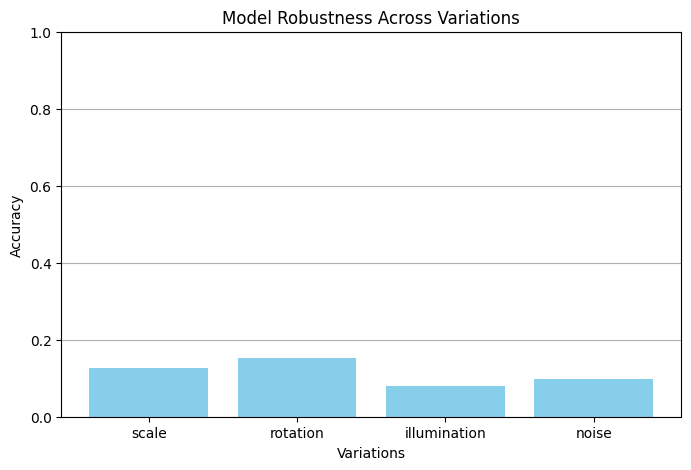

Total time for entire process: 499.35 seconds


In [7]:
import time

# -------------------- CONFIGURATION --------------------
input_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_variations"
k3 = 700  # Number of clusters
descriptor_extension = "_desc.npy"
missing_files_log = "missing_files.log"

# Helper functions
def generate_histogram(descriptors, kmeans_model):
    histogram = np.zeros(kmeans_model.n_clusters)
    clusters = kmeans_model.predict(descriptors)
    for cluster in clusters:
        histogram[cluster] += 1
    return histogram

def extract_descriptors_from_saved(image_paths):
    descriptors_list = []
    labels = []
    missing_files = []

    for image_path in image_paths:
        desc_file_path = os.path.splitext(image_path)[0] + descriptor_extension
        if os.path.exists(desc_file_path):
            descriptors = np.load(desc_file_path)
            descriptors_list.append(descriptors)
            label = os.path.basename(os.path.dirname(image_path))
            labels.append(label)
        else:
            missing_files.append(image_path)

    # Log missing files
    if missing_files:
        with open(missing_files_log, "w") as log:
            log.writelines(f"{file}\n" for file in missing_files)
        print(f"Logged {len(missing_files)} missing files to '{missing_files_log}'.")

    return descriptors_list, labels

def regenerate_missing_descriptors(log_file):
    if not os.path.exists(log_file):
        print(f"Missing files log '{log_file}' not found.")
        return

    orb = cv2.ORB_create()
    with open(log_file, "r") as f:
        missing_files = f.read().splitlines()

    for image_path in missing_files:
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        # Load the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue

        # Detect keypoints and compute descriptors
        keypoints, descriptors = orb.detectAndCompute(img, None)

        # Save descriptors
        if descriptors is not None:
            desc_file_path = os.path.splitext(image_path)[0] + descriptor_extension
            np.save(desc_file_path, descriptors)
            print(f"Regenerated descriptor for: {image_path}")

# -------------------- STEP 1: TRAIN KMEANS (BOVW) --------------------
print("Combining training data from all variations...")
train_image_paths = []
variations = ["scale", "rotation", "illumination", "noise"]

# Gather all training image paths from all variations
for variation in variations:
    variation_train_dir = os.path.join(input_dir, variation, "train")
    train_image_paths.extend(glob(f"{variation_train_dir}/**/*.png", recursive=True))

print(f"Total training images: {len(train_image_paths)}")

# Extract descriptors and labels from all variations
step_start = time.time()
train_descriptors_list, train_labels = extract_descriptors_from_saved(train_image_paths)

# Regenerate missing descriptors if any
if os.path.exists(missing_files_log):
    print("Regenerating missing descriptors...")
    regenerate_missing_descriptors(missing_files_log)

# Reload descriptors after regeneration
train_descriptors_list, train_labels = extract_descriptors_from_saved(train_image_paths)

all_descriptors = np.vstack(train_descriptors_list)
print(f"Total descriptors shape: {all_descriptors.shape}")
print(f"Time for descriptor extraction: {time.time() - step_start:.2f} seconds")

# Train KMeans
step_start = time.time()
print("Training KMeans to create visual words...")
kmeans = KMeans(n_clusters=k3, random_state=42)
kmeans.fit(all_descriptors)
print(f"KMeans training complete in {time.time() - step_start:.2f} seconds.")

# Generate histograms for training set
step_start = time.time()
X_train_raw = [generate_histogram(des, kmeans) for des in train_descriptors_list]
Y_train = np.array(train_labels)
print(f"Time for histogram generation: {time.time() - step_start:.2f} seconds")

# Compute TF-IDF weights
step_start = time.time()
print("Applying TF-IDF weighting...")
tfidf = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
X_train_tfidf = tfidf.fit_transform(X_train_raw).toarray()
print(f"Time for TF-IDF computation: {time.time() - step_start:.2f} seconds")

# -------------------- STEP 2: TRAIN SVM --------------------
step_start = time.time()
print("Training SVM classifier...")
svm = SVC(kernel='rbf', C=10, gamma=1)
svm.fit(X_train_tfidf, Y_train)
print(f"SVM training complete in {time.time() - step_start:.2f} seconds.")

# -------------------- STEP 3: EVALUATE ON TEST SET --------------------
print("Evaluating on all variations...")
variation_accuracies = {}

for variation in variations:
    print(f"\nEvaluating variation: {variation}")
    test_dir = os.path.join(input_dir, variation, "test")
    test_image_paths = glob(f"{test_dir}/**/*.png", recursive=True)

    # Extract descriptors and labels for the test set
    step_start = time.time()
    test_descriptors_list, test_labels = extract_descriptors_from_saved(test_image_paths)
    print(f"Time for extracting test descriptors: {time.time() - step_start:.2f} seconds")

    # Generate histograms for test set
    step_start = time.time()
    X_test_raw = [generate_histogram(des, kmeans) for des in test_descriptors_list]
    print(f"Time for test histogram generation: {time.time() - step_start:.2f} seconds")

    # Apply TF-IDF transformation
    step_start = time.time()
    X_test_tfidf = tfidf.transform(X_test_raw).toarray()
    print(f"Time for TF-IDF transformation on test data: {time.time() - step_start:.2f} seconds")

    # Predict using the trained SVM
    step_start = time.time()
    Y_pred = svm.predict(X_test_tfidf)
    print(f"Time for SVM prediction: {time.time() - step_start:.2f} seconds")

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, Y_pred)
    variation_accuracies[variation] = accuracy

    # Print metrics
    print(f"Accuracy for {variation}: {accuracy:.2f}")
    print("Confusion Matrix:")
    print(confusion_matrix(test_labels, Y_pred))
    print("Classification Report:")
    print(classification_report(test_labels, Y_pred, zero_division=1))

# -------------------- FINAL RESULTS --------------------
print("\nSummary of accuracies across variations:")
for variation, accuracy in variation_accuracies.items():
    print(f"{variation.capitalize()}: {accuracy:.2f}")

# Visualize accuracies
plt.figure(figsize=(8, 5))
plt.bar(variation_accuracies.keys(), variation_accuracies.values(), color='skyblue')
plt.title("Model Robustness Across Variations")
plt.xlabel("Variations")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

print(f"Total time for entire process: {time.time() - step_start:.2f} seconds")

# ORB algorithm after variation with EVALUATION METRICES (ACCURACCY, TIME EFFICIENCY, NUMBER OF KEYPOINTS)

In [6]:
# Define the input and output directories
input_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final\scale"
output_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_newVARIATION_scale"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# ORB detector initialization
orb = cv2.ORB_create()

# Metrics collection
metrics = {
    "total_images": 0,
    "total_keypoints": 0,
    "total_time": 0.0,
    "images_processed": []
}

def process_with_orb(image_path, output_img_path, output_desc_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return {"num_keypoints": 0, "feature_extraction_time": 0.0}

    start_time = time.time()
    keypoints, descriptors = orb.detectAndCompute(img, None)
    elapsed_time = time.time() - start_time

    output_image = cv2.drawKeypoints(img, keypoints, None, color=(255, 0, 255), flags=0)
    cv2.imwrite(output_img_path, output_image)

    if descriptors is not None:
        np.save(output_desc_path, descriptors)

    return {"num_keypoints": len(keypoints), "feature_extraction_time": elapsed_time}

# Process all images
for file_path in glob(f"{input_dir}/**/*.png", recursive=True):
    relative_path = os.path.relpath(file_path, input_dir)
    output_img_path = os.path.join(output_dir, relative_path)
    output_desc_path = os.path.splitext(output_img_path)[0] + "_desc.npy"
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    result = process_with_orb(file_path, output_img_path, output_desc_path)
    metrics["total_images"] += 1
    metrics["total_keypoints"] += result["num_keypoints"]
    metrics["total_time"] += result["feature_extraction_time"]
    metrics["images_processed"].append({
        "file_path": file_path,
        "num_keypoints": result["num_keypoints"],
        "feature_extraction_time": result["feature_extraction_time"]
    })

# Calculate averages
average_keypoints = metrics["total_keypoints"] / metrics["total_images"] if metrics["total_images"] > 0 else 0
average_time = metrics["total_time"] / metrics["total_images"] if metrics["total_images"] > 0 else 0

# Output metrics
print("ORB feature extraction complete for all images.")
print(f"Total Images Processed: {metrics['total_images']}")
print(f"Total Keypoints Detected: {metrics['total_keypoints']}")
print(f"Average Keypoints per Image: {average_keypoints:.2f}")
print(f"Total Feature Extraction Time: {metrics['total_time']:.2f} seconds")
print(f"Average Feature Extraction Time per Image: {average_time:.2f} seconds")

ORB feature extraction complete for all images.
Total Images Processed: 32576
Total Keypoints Detected: 1789436
Average Keypoints per Image: 54.93
Total Feature Extraction Time: 42.97 seconds
Average Feature Extraction Time per Image: 0.00 seconds


In [7]:
# Define the input and output directories
input_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final\rotation"
output_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_newVARIATION_rotation"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# ORB detector initialization
orb = cv2.ORB_create()

# Metrics collection
metrics = {
    "total_images": 0,
    "total_keypoints": 0,
    "total_time": 0.0,
    "images_processed": []
}

def process_with_orb(image_path, output_img_path, output_desc_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return {"num_keypoints": 0, "feature_extraction_time": 0.0}

    start_time = time.time()
    keypoints, descriptors = orb.detectAndCompute(img, None)
    elapsed_time = time.time() - start_time

    output_image = cv2.drawKeypoints(img, keypoints, None, color=(255, 0, 255), flags=0)
    cv2.imwrite(output_img_path, output_image)

    if descriptors is not None:
        np.save(output_desc_path, descriptors)

    return {"num_keypoints": len(keypoints), "feature_extraction_time": elapsed_time}

# Process all images
for file_path in glob(f"{input_dir}/**/*.png", recursive=True):
    relative_path = os.path.relpath(file_path, input_dir)
    output_img_path = os.path.join(output_dir, relative_path)
    output_desc_path = os.path.splitext(output_img_path)[0] + "_desc.npy"
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    result = process_with_orb(file_path, output_img_path, output_desc_path)
    metrics["total_images"] += 1
    metrics["total_keypoints"] += result["num_keypoints"]
    metrics["total_time"] += result["feature_extraction_time"]
    metrics["images_processed"].append({
        "file_path": file_path,
        "num_keypoints": result["num_keypoints"],
        "feature_extraction_time": result["feature_extraction_time"]
    })

# Calculate averages
average_keypoints = metrics["total_keypoints"] / metrics["total_images"] if metrics["total_images"] > 0 else 0
average_time = metrics["total_time"] / metrics["total_images"] if metrics["total_images"] > 0 else 0

# Output metrics
print("ORB feature extraction complete for all images.")
print(f"Total Images Processed: {metrics['total_images']}")
print(f"Total Keypoints Detected: {metrics['total_keypoints']}")
print(f"Average Keypoints per Image: {average_keypoints:.2f}")
print(f"Total Feature Extraction Time: {metrics['total_time']:.2f} seconds")
print(f"Average Feature Extraction Time per Image: {average_time:.2f} seconds")

ORB feature extraction complete for all images.
Total Images Processed: 24432
Total Keypoints Detected: 1406372
Average Keypoints per Image: 57.56
Total Feature Extraction Time: 42.56 seconds
Average Feature Extraction Time per Image: 0.00 seconds


In [8]:
# Define the input and output directories
input_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final\noise"
output_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_newVARIATION_noise"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# ORB detector initialization
orb = cv2.ORB_create()

# Metrics collection
metrics = {
    "total_images": 0,
    "total_keypoints": 0,
    "total_time": 0.0,
    "images_processed": []
}

def process_with_orb(image_path, output_img_path, output_desc_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return {"num_keypoints": 0, "feature_extraction_time": 0.0}

    start_time = time.time()
    keypoints, descriptors = orb.detectAndCompute(img, None)
    elapsed_time = time.time() - start_time

    output_image = cv2.drawKeypoints(img, keypoints, None, color=(255, 0, 255), flags=0)
    cv2.imwrite(output_img_path, output_image)

    if descriptors is not None:
        np.save(output_desc_path, descriptors)

    return {"num_keypoints": len(keypoints), "feature_extraction_time": elapsed_time}

# Process all images
for file_path in glob(f"{input_dir}/**/*.png", recursive=True):
    relative_path = os.path.relpath(file_path, input_dir)
    output_img_path = os.path.join(output_dir, relative_path)
    output_desc_path = os.path.splitext(output_img_path)[0] + "_desc.npy"
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    result = process_with_orb(file_path, output_img_path, output_desc_path)
    metrics["total_images"] += 1
    metrics["total_keypoints"] += result["num_keypoints"]
    metrics["total_time"] += result["feature_extraction_time"]
    metrics["images_processed"].append({
        "file_path": file_path,
        "num_keypoints": result["num_keypoints"],
        "feature_extraction_time": result["feature_extraction_time"]
    })

# Calculate averages
average_keypoints = metrics["total_keypoints"] / metrics["total_images"] if metrics["total_images"] > 0 else 0
average_time = metrics["total_time"] / metrics["total_images"] if metrics["total_images"] > 0 else 0

# Output metrics
print("ORB feature extraction complete for all images.")
print(f"Total Images Processed: {metrics['total_images']}")
print(f"Total Keypoints Detected: {metrics['total_keypoints']}")
print(f"Average Keypoints per Image: {average_keypoints:.2f}")
print(f"Total Feature Extraction Time: {metrics['total_time']:.2f} seconds")
print(f"Average Feature Extraction Time per Image: {average_time:.2f} seconds")

ORB feature extraction complete for all images.
Total Images Processed: 16288
Total Keypoints Detected: 2168169
Average Keypoints per Image: 133.11
Total Feature Extraction Time: 29.64 seconds
Average Feature Extraction Time per Image: 0.00 seconds


In [9]:
# Define the input and output directories
input_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final\illumination"
output_dir = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\orbKeypoints_split_newVARIATION_illumination"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# ORB detector initialization
orb = cv2.ORB_create()

# Metrics collection
metrics = {
    "total_images": 0,
    "total_keypoints": 0,
    "total_time": 0.0,
    "images_processed": []
}

def process_with_orb(image_path, output_img_path, output_desc_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return {"num_keypoints": 0, "feature_extraction_time": 0.0}

    start_time = time.time()
    keypoints, descriptors = orb.detectAndCompute(img, None)
    elapsed_time = time.time() - start_time

    output_image = cv2.drawKeypoints(img, keypoints, None, color=(255, 0, 255), flags=0)
    cv2.imwrite(output_img_path, output_image)

    if descriptors is not None:
        np.save(output_desc_path, descriptors)

    return {"num_keypoints": len(keypoints), "feature_extraction_time": elapsed_time}

# Process all images
for file_path in glob(f"{input_dir}/**/*.png", recursive=True):
    relative_path = os.path.relpath(file_path, input_dir)
    output_img_path = os.path.join(output_dir, relative_path)
    output_desc_path = os.path.splitext(output_img_path)[0] + "_desc.npy"
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    result = process_with_orb(file_path, output_img_path, output_desc_path)
    metrics["total_images"] += 1
    metrics["total_keypoints"] += result["num_keypoints"]
    metrics["total_time"] += result["feature_extraction_time"]
    metrics["images_processed"].append({
        "file_path": file_path,
        "num_keypoints": result["num_keypoints"],
        "feature_extraction_time": result["feature_extraction_time"]
    })

# Calculate averages
average_keypoints = metrics["total_keypoints"] / metrics["total_images"] if metrics["total_images"] > 0 else 0
average_time = metrics["total_time"] / metrics["total_images"] if metrics["total_images"] > 0 else 0

# Output metrics
print("ORB feature extraction complete for all images.")
print(f"Total Images Processed: {metrics['total_images']}")
print(f"Total Keypoints Detected: {metrics['total_keypoints']}")
print(f"Average Keypoints per Image: {average_keypoints:.2f}")
print(f"Total Feature Extraction Time: {metrics['total_time']:.2f} seconds")
print(f"Average Feature Extraction Time per Image: {average_time:.2f} seconds")

ORB feature extraction complete for all images.
Total Images Processed: 16288
Total Keypoints Detected: 539474
Average Keypoints per Image: 33.12
Total Feature Extraction Time: 28.41 seconds
Average Feature Extraction Time per Image: 0.00 seconds


# SIFT algorithm after variation with EVALUATION METRICES (ACCURACCY, TIME EFFICIENCY, NUMBER OF KEYPOINTS)

In [14]:
dataset_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final\scale"
output_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_newVARIATION_scale"

# Ensure output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# SIFT detector initialization
sift = cv2.SIFT_create()

# Function to process images with SIFT and save results
def process_with_sift(image_path, output_img_path, output_desc_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Detect SIFT keypoints and descriptors
    start_time = time.time()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    elapsed_time = time.time() - start_time

    # Draw the keypoints on the image
    output_image = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Save the resulting image with keypoints drawn
    cv2.imwrite(output_img_path, output_image)

    # Save the descriptors to a .npy file
    if descriptors is not None:
        output_desc_path = os.path.splitext(output_img_path)[0] + "_descSIFT.npy"
        np.save(output_desc_path, descriptors)  # Save descriptors as .npy files

    # Return the evaluation metrics for this image
    return {
        "num_keypoints": len(keypoints),
        "feature_extraction_time": elapsed_time
    }

# Metrics collection
metrics = {
    "total_images": 0,
    "total_keypoints": 0,
    "total_time": 0.0,
    "images_processed": []
}

# Process all images in the dataset
for file_path in glob(f"{dataset_path}/**/*.png", recursive=True):
    # Create the corresponding output paths
    relative_path = os.path.relpath(file_path, dataset_path)
    output_img_path = os.path.join(output_path, relative_path)
    output_desc_path = os.path.splitext(output_img_path)[0] + "_descSIFT.npy"  # Descriptor file path

    # Ensure the output folder exists
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    # Apply SIFT and save results, collecting metrics
    result = process_with_sift(file_path, output_img_path, output_desc_path)

    # Update metrics
    metrics["total_images"] += 1
    metrics["total_keypoints"] += result["num_keypoints"]
    metrics["total_time"] += result["feature_extraction_time"]
    metrics["images_processed"].append({
        "file_path": file_path,
        "num_keypoints": result["num_keypoints"],
        "feature_extraction_time": result["feature_extraction_time"]
    })

# Calculate average metrics
average_keypoints = metrics["total_keypoints"] / metrics["total_images"] if metrics["total_images"] > 0 else 0
average_time = metrics["total_time"] / metrics["total_images"] if metrics["total_images"] > 0 else 0

# Print evaluation metrics
print("SIFT feature extraction complete for all images.")
print(f"Total Images Processed: {metrics['total_images']}")
print(f"Total Keypoints Detected: {metrics['total_keypoints']}")
print(f"Average Keypoints per Image: {average_keypoints:.2f}")
print(f"Total Feature Extraction Time: {metrics['total_time']:.2f} seconds")
print(f"Average Feature Extraction Time per Image: {average_time:.2f} seconds")

SIFT feature extraction complete for all images.
Total Images Processed: 32576
Total Keypoints Detected: 1355650
Average Keypoints per Image: 41.61
Total Feature Extraction Time: 510.80 seconds
Average Feature Extraction Time per Image: 0.02 seconds


In [15]:
dataset_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final\rotation"
output_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_newVARIATION_rotation"

# Ensure output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# SIFT detector initialization
sift = cv2.SIFT_create()

# Function to process images with SIFT and save results
def process_with_sift(image_path, output_img_path, output_desc_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Detect SIFT keypoints and descriptors
    start_time = time.time()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    elapsed_time = time.time() - start_time

    # Draw the keypoints on the image
    output_image = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Save the resulting image with keypoints drawn
    cv2.imwrite(output_img_path, output_image)

    # Return the evaluation metrics for this image
    return {
        "num_keypoints": len(keypoints),
        "feature_extraction_time": elapsed_time
    }

# Metrics collection
metrics = {
    "total_images": 0,
    "total_keypoints": 0,
    "total_time": 0.0,
    "images_processed": []
}

# Process all images in the dataset
for file_path in glob(f"{dataset_path}/**/*.png", recursive=True):
    # Create the corresponding output paths
    relative_path = os.path.relpath(file_path, dataset_path)
    output_img_path = os.path.join(output_path, relative_path)

    # Ensure the output folder exists
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    # Apply SIFT and save results, collecting metrics
    result = process_with_sift(file_path, output_img_path, output_desc_path)

    # Update metrics
    metrics["total_images"] += 1
    metrics["total_keypoints"] += result["num_keypoints"]
    metrics["total_time"] += result["feature_extraction_time"]
    metrics["images_processed"].append({
        "file_path": file_path,
        "num_keypoints": result["num_keypoints"],
        "feature_extraction_time": result["feature_extraction_time"]
    })

# Calculate average metrics
average_keypoints = metrics["total_keypoints"] / metrics["total_images"] if metrics["total_images"] > 0 else 0
average_time = metrics["total_time"] / metrics["total_images"] if metrics["total_images"] > 0 else 0

# Print evaluation metrics
print("SIFT feature extraction complete for all images.")
print(f"Total Images Processed: {metrics['total_images']}")
print(f"Total Keypoints Detected: {metrics['total_keypoints']}")
print(f"Average Keypoints per Image: {average_keypoints:.2f}")
print(f"Total Feature Extraction Time: {metrics['total_time']:.2f} seconds")
print(f"Average Feature Extraction Time per Image: {average_time:.2f} seconds")

SIFT feature extraction complete for all images.
Total Images Processed: 24432
Total Keypoints Detected: 1248682
Average Keypoints per Image: 51.11
Total Feature Extraction Time: 271.63 seconds
Average Feature Extraction Time per Image: 0.01 seconds


In [16]:
dataset_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final\noise"
output_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_newVARIATION_noise"

# Ensure output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# SIFT detector initialization
sift = cv2.SIFT_create()

# Function to process images with SIFT and save results
def process_with_sift(image_path, output_img_path, output_desc_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Detect SIFT keypoints and descriptors
    start_time = time.time()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    elapsed_time = time.time() - start_time

    # Draw the keypoints on the image
    output_image = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Save the resulting image with keypoints drawn
    cv2.imwrite(output_img_path, output_image)


    # Return the evaluation metrics for this image
    return {
        "num_keypoints": len(keypoints),
        "feature_extraction_time": elapsed_time
    }

# Metrics collection
metrics = {
    "total_images": 0,
    "total_keypoints": 0,
    "total_time": 0.0,
    "images_processed": []
}

# Process all images in the dataset
for file_path in glob(f"{dataset_path}/**/*.png", recursive=True):
    # Create the corresponding output paths
    relative_path = os.path.relpath(file_path, dataset_path)
    output_img_path = os.path.join(output_path, relative_path)

    # Ensure the output folder exists
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    # Apply SIFT and save results, collecting metrics
    result = process_with_sift(file_path, output_img_path, output_desc_path)

    # Update metrics
    metrics["total_images"] += 1
    metrics["total_keypoints"] += result["num_keypoints"]
    metrics["total_time"] += result["feature_extraction_time"]
    metrics["images_processed"].append({
        "file_path": file_path,
        "num_keypoints": result["num_keypoints"],
        "feature_extraction_time": result["feature_extraction_time"]
    })

# Calculate average metrics
average_keypoints = metrics["total_keypoints"] / metrics["total_images"] if metrics["total_images"] > 0 else 0
average_time = metrics["total_time"] / metrics["total_images"] if metrics["total_images"] > 0 else 0

# Print evaluation metrics
print("SIFT feature extraction complete for all images.")
print(f"Total Images Processed: {metrics['total_images']}")
print(f"Total Keypoints Detected: {metrics['total_keypoints']}")
print(f"Average Keypoints per Image: {average_keypoints:.2f}")
print(f"Total Feature Extraction Time: {metrics['total_time']:.2f} seconds")
print(f"Average Feature Extraction Time per Image: {average_time:.2f} seconds")

SIFT feature extraction complete for all images.
Total Images Processed: 16288
Total Keypoints Detected: 771836
Average Keypoints per Image: 47.39
Total Feature Extraction Time: 94.01 seconds
Average Feature Extraction Time per Image: 0.01 seconds


In [17]:
dataset_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\transformed_dataset_final\illumination"
output_path = r"C:\Users\asus\OneDrive\Desktop\Computer Vision\assignment2\siftKeypoints_split_newVARIATION_illumination"

# Ensure output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# SIFT detector initialization
sift = cv2.SIFT_create()

# Function to process images with SIFT and save results
def process_with_sift(image_path, output_img_path, output_desc_path):
    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Detect SIFT keypoints and descriptors
    start_time = time.time()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    elapsed_time = time.time() - start_time

    # Draw the keypoints on the image
    output_image = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Save the resulting image with keypoints drawn
    cv2.imwrite(output_img_path, output_image)

    # Return the evaluation metrics for this image
    return {
        "num_keypoints": len(keypoints),
        "feature_extraction_time": elapsed_time
    }

# Metrics collection
metrics = {
    "total_images": 0,
    "total_keypoints": 0,
    "total_time": 0.0,
    "images_processed": []
}

# Process all images in the dataset
for file_path in glob(f"{dataset_path}/**/*.png", recursive=True):
    # Create the corresponding output paths
    relative_path = os.path.relpath(file_path, dataset_path)
    output_img_path = os.path.join(output_path, relative_path)

    # Ensure the output folder exists
    os.makedirs(os.path.dirname(output_img_path), exist_ok=True)

    # Apply SIFT and save results, collecting metrics
    result = process_with_sift(file_path, output_img_path, output_desc_path)

    # Update metrics
    metrics["total_images"] += 1
    metrics["total_keypoints"] += result["num_keypoints"]
    metrics["total_time"] += result["feature_extraction_time"]
    metrics["images_processed"].append({
        "file_path": file_path,
        "num_keypoints": result["num_keypoints"],
        "feature_extraction_time": result["feature_extraction_time"]
    })

# Calculate average metrics
average_keypoints = metrics["total_keypoints"] / metrics["total_images"] if metrics["total_images"] > 0 else 0
average_time = metrics["total_time"] / metrics["total_images"] if metrics["total_images"] > 0 else 0

# Print evaluation metrics
print("SIFT feature extraction complete for all images.")
print(f"Total Images Processed: {metrics['total_images']}")
print(f"Total Keypoints Detected: {metrics['total_keypoints']}")
print(f"Average Keypoints per Image: {average_keypoints:.2f}")
print(f"Total Feature Extraction Time: {metrics['total_time']:.2f} seconds")
print(f"Average Feature Extraction Time per Image: {average_time:.2f} seconds")

SIFT feature extraction complete for all images.
Total Images Processed: 16288
Total Keypoints Detected: 467138
Average Keypoints per Image: 28.68
Total Feature Extraction Time: 98.32 seconds
Average Feature Extraction Time per Image: 0.01 seconds
